In [221]:
from typing import Callable, List
from functools import partial, reduce

import numpy as np
import matplotlib.pyplot as plt
from numpy import ndarray

plt.rcParams["figure.figsize"] = (20,10)

In [222]:
"""
Finds gradient of function fun in point x with precision h.
"""
def grad(fun:Callable[[ndarray], float], x:ndarray, h:float=1e-5) -> ndarray:
    dim = len(x)
    g = np.zeros(dim)
    step = np.zeros(dim)
    for i in range(dim):
        step[i] = h
        g[i] = (fun(x + step) - fun(x - step)) / (2 * h)
        step[i] = 0
    return g

"""
Finds "partial" gradient of function represented in the form of sum.
Calculates sum of derivatives of some terms of function fun in a row.

@param fun: list of terms of the function to find partial gradient for
@param x: point in which derivatives are calculated
@param r: list of 2 elements. 1 element shows the first term in list fun for which gradiant will be found. 2 element shows for how many terms after first term gradient will be found
@param h: precision of calculated gradients

@returns r[1] dimensional list containing sum of calculated gradients
"""
def grad_appr(fun:List[Callable[[ndarray], float]], x:ndarray, r:List=(0, 1), h:float=1e-5) -> ndarray:
    sum = np.zeros(len(x))
    begin = r[0]
    n = r[1]
    for i in range(n):
        sum += grad(fun[(begin + i) % len(fun)], x, h)
    return sum

"""
Generates cartesian product of points in arrays.

Это функция взята с Stack Overflow, я понятия не имею, как она работает, и не хочу иметь.
"""
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

"""
Generates data set for multiple linear regression.
Guaranteed that expected value of noise equals to 0. Every regressor is len(b) - 1 dimensional vector.
Both regressors and dependent variables lists has size equals to len(t) ** (len(b) - 1).


Для облегчения понимания можно считать, что функция генерирует точки, смещённые относительно некоторой гиперплоскости вверх или вниз.

p[1:] в некотором роде задаёт нормаль к этой гиперплоскости. p[0] - смещение гиперплоскости вверх или вниз относительно начала координат, length - её длина. k или шум характеризует то, насколько сгенерированные точки будут отклоняться от гиперплоскости, которую мы приближаем. num - количество точек на гиперплоскости.

В итоге получается два массива: точки на гиперплоскости и высоты этих точек.


@param b: list characterising linear relationship between regressors (independent variables) and dependent variable. b[0] is dependent variable offset
@param k: noise (error term) max absolute value
@param t: list describing basis linspace for dataset

@return list of two elements: list of regressors and list of dependent values
"""
def generate_dataset(b:List, k:int, t:ndarray = np.linspace(0, 10, 50)) -> List[List]:
    # t += (np.random.rand(len(t)) - 0.5) * 2 * k
    h, b = b[0], b[1:]
    dim = len(b)
    # *[t]*dim is equals to *np.tile(t, dim).reshape((dim, -1))
    regressors = cartesian_product(*[t]*dim)
    # Noise
    e = (np.random.rand(len(regressors)) - 0.5) * 2 * k
    dependent_var = (b * cartesian_product(*[t]*dim)).sum(axis=1) + h + e
    return [regressors, dependent_var]

"""
Generates function which minimum point is the solution for linear regression problem for dataset [t, ft].
It is pretty slow.

@param t: list of regressors
@param ft: list of dependent values

@return list of terms of generated function (every term represents distance from minimized function to one point from dataset)
"""
def generate_minimized_fun(t:List, ft:List) -> List[Callable[[List], float]]:
    sum_fun = np.empty(len(t), dtype=partial)
    for i in range(len(t)):
        # Captures t[i], ft[i] and len(t) from current context
        sum_fun[i] = partial(lambda t, ft, l, a: 1 / (2 * l) * np.square(a[0] + np.sum(a[1:] * t) - ft), t[i], ft[i], len(t))
        # or
        # sum_fun[i] = partial(lambda t, ft, l, a: 1 / (2 * l) * np.square(np.sum(a * np.concatenate(([1], t))) - ft), t[i], ft[i], len(t))
    np.random.shuffle(sum_fun)
    return sum_fun

"""
Generates function which minimum point is the solution for linear regression problem for dataset [t, ft].
Similar to generate_minimized_fun but every regressor is 1 dimensional vector (i.e. minimized function has two arguments). You should use this function only when it's necessary to plot minimized function. Function generated by generate_minimized_two_variable_fun works fine when arguments are arrays unlike generate_minimized_fun.

@param t: list of regressors
@param ft: list of dependent values

@return list of terms of generated function (every term represents distance from generated function to one point from dataset)
"""
def generate_minimized_two_variable_fun(t:List, ft:List) -> List[Callable[[List], float]]:
    sum_fun = np.empty(len(t), dtype=partial)
    for i in range(len(t)):
        # Captures t[i], ft[i] and len(t) from current context
        sum_fun[i] = partial(lambda t, ft, l, a: 1 / (2 * l) * np.square(a[0] + a[1] * t - ft), t[i], ft[i], len(t))
    np.random.shuffle(sum_fun)
    return sum_fun

"""
Generates function from terms. Every term is function. Every function from terms should accept equal amount of parameters.

@return function representing sum of functions from terms
"""
def fun_from_terms(terms):
    return reduce(lambda f1, f2: lambda x: f1(x) + f2(x), terms)

"""
Finds minimum of the function sum_fun using stochastic gradient descent (sgd).

@return list of points representing path of sgd. The last point of the list is found minimum point.
"""
def sgd(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    for i in range(1, epoch):
        x = x - 1 / batch_size * scheduler(lr) * np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        points[i] = x
    return points

## Решение задачи простой линейной регрессии (одномерное пространство регрессоров)
Приближает прямую в двумерном пространстве

[-0.52666906  0.00140186]
[10.52666906  4.99859814]
[[ 0.          0.        ]
 [ 2.3834324   1.73989597]
 [ 4.51384497  3.04250378]
 [ 6.19922151  3.67441788]
 [ 8.09842192  4.33269006]
 [ 8.39577673  4.49902555]
 [ 9.3504674   4.80403635]
 [ 8.77919649  5.01720982]
 [ 8.79083353  5.04458546]
 [ 9.33540501  4.96300483]
 [ 8.80184073  4.96712054]
 [ 8.81272564  5.13501616]
 [ 8.8034248   5.13779056]
 [ 9.05755035  4.98901965]
 [ 9.07209734  5.07692413]
 [ 8.98534801  5.06471534]
 [ 9.38596265  5.115446  ]
 [ 9.44675763  5.12726761]
 [ 9.8159278   5.06038395]
 [10.52666906  4.99859814]]


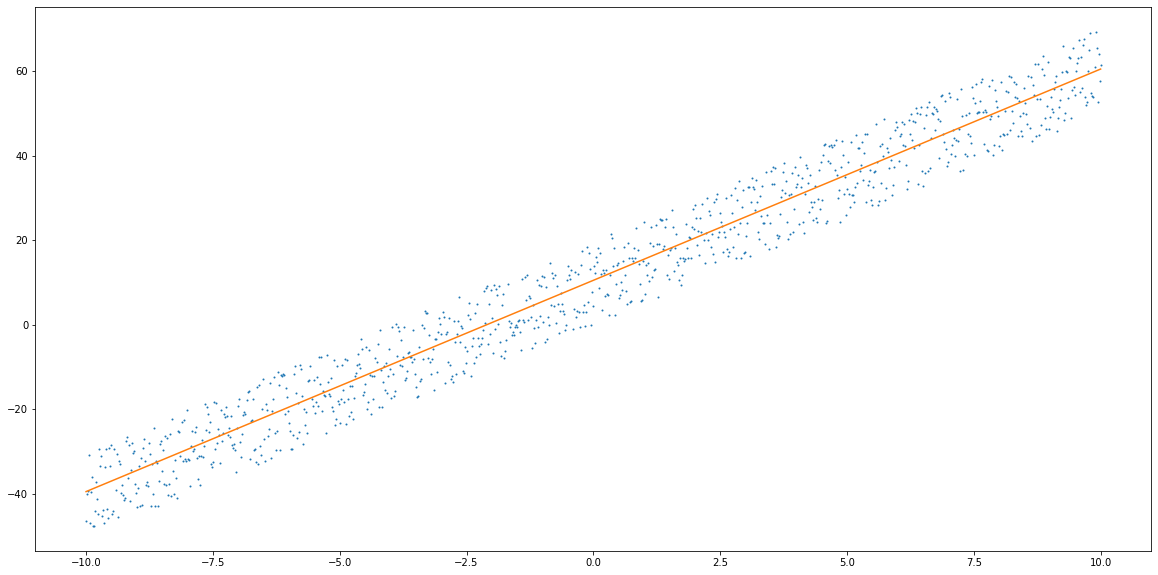

In [223]:
tt = np.linspace(-10, 10, 1000)
b = [10, 5]
t, ft = generate_dataset(b, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = [200, 10]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(b - min_point)
print(min_point)
print(points)

# Plots dataset
plt.plot(t, ft, 'o', markersize=1)
# Plots approximated function
plt.plot(tt, min_point[1] * tt + min_point[0])

## Решение задачи линейной регрессии (для двумерного пространства регрессоров)
Приближает плоскость в трёхмерном пространстве

[0.35603415 0.18223214 0.05065495]
[9.64396585 1.81776786 3.94934505]
[[0.         0.         0.        ]
 [0.8097232  0.18552288 0.63850461]
 [0.9659745  0.31101233 0.93639616]
 [1.69918515 0.43350506 1.27813644]
 [2.26615062 0.49924632 1.60561881]
 [3.00131383 0.57844275 1.91280631]
 [3.52480948 0.63462546 2.20030744]
 [4.05111323 0.69978143 2.43506382]
 [4.66568525 0.81590753 2.77387613]
 [5.01174934 0.86113237 2.90089673]
 [5.212672   0.90816629 3.00054942]
 [5.62485005 0.94878242 3.07700615]
 [5.74066059 1.05932655 3.24784308]
 [5.80895517 1.10189949 3.36893675]
 [6.16764876 1.15903979 3.3911189 ]
 [6.28160559 1.1956385  3.54541412]
 [6.55879537 1.24124516 3.6155382 ]
 [6.74609364 1.25911334 3.66441201]
 [7.06411867 1.29325889 3.74607581]
 [7.44457894 1.32514219 3.81429267]
 [7.74564103 1.36432084 3.8440467 ]
 [8.04206132 1.39587472 3.86809265]
 [8.09845134 1.4222995  3.86407191]
 [8.28352357 1.46263131 3.91392659]
 [8.40889317 1.46482588 3.8978363 ]
 [8.63304981 1.50257216 3.8662

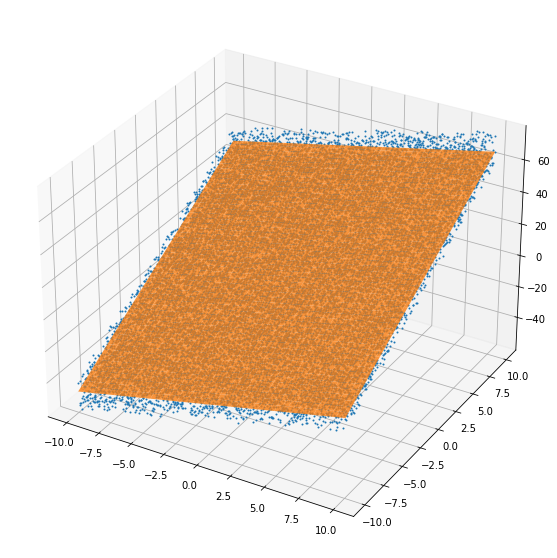

In [224]:
tt = np.linspace(-10, 10, 150)
b = [10, 2, 4]
t, ft = generate_dataset(b, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(3)
epoch = 50
batch_size = 20
lr = [1500, 40, 80]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(b - min_point)
print(min_point)
print(points)

ax = plt.figure().add_subplot(projection='3d')
# Plots dataset
ax.plot(t[:, 0], t[:, 1], ft, 'o', markersize=1)
# Plots approximated function
X, Y = np.meshgrid(tt, tt)
ax.plot_surface(X, Y, min_point[0] + min_point[1] * X + min_point[2] * Y, alpha=0.8)

## 4-мерное пространство регрессоров

In [225]:
tt = np.linspace(-10, 10, 20)
b = [10, 2, 4, 5, -3]
t, ft = generate_dataset(b, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(5)
epoch = 50
batch_size = 3
lr = [7500, 120, 160, 200, 120]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(b - min_point)
print(min_point)
print(points)

[ 0.18763676  0.30709643  0.75284935  0.59407255 -0.90987805]
[ 9.81236324  1.69290357  3.24715065  4.40592745 -2.09012195]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 6.05573743e-01 -9.57271266e-03  8.07578617e-02  9.60672851e-02
   4.28934102e-02]
 [ 2.46100323e+00  1.12733012e-01  2.86557387e-01  1.03601719e-02
  -1.29003076e-01]
 [ 4.44416525e+00  3.33582391e-01  5.75908732e-01  3.93440996e-01
  -2.29952358e-01]
 [ 5.07987453e+00  3.42560308e-01  6.03564139e-01  4.00125582e-01
  -2.29625477e-01]
 [ 4.64544209e+00  3.65098982e-01  5.86999822e-01  4.33025573e-01
  -2.46706896e-01]
 [ 4.88388477e+00  4.06238355e-01  8.30463781e-01  8.36853063e-01
  -2.60572267e-01]
 [ 5.16324320e+00  3.78081237e-01  7.84705925e-01  1.08920861e+00
  -3.02861881e-01]
 [ 5.81910943e+00  2.37673050e-01  8.54013908e-01  1.31977540e+00
  -4.23483358e-01]
 [ 5.57987159e+00  3.29421369e-01  8.96030077e-01  1.48806126e+00
  -4.22300930e-01]
 [ 6.08773305e+00  3.83632

## Сходимость в зависимости от размера batch
Двумерное пространство регрессоров

[[-0.30982781 -0.0166201   0.27533928]
 [ 0.92487824  0.04198097 -0.28166507]
 [ 0.26230046  0.03630486 -0.05662695]
 [ 0.71550779  0.03661603 -0.27300591]
 [ 0.89662368  0.08542085 -0.20697887]
 [ 0.56987303  0.05852474 -0.15857547]
 [ 0.90083775  0.06633912 -0.22177811]
 [ 0.41993466  0.04404331 -0.11125806]
 [ 0.90084177  0.05562022 -0.21772253]
 [ 0.6138174   0.05247978 -0.11619032]
 [ 0.77306356  0.04690428 -0.17295895]
 [ 0.79666493  0.06481042 -0.12035549]
 [ 0.71680893  0.06102759 -0.14438146]
 [ 0.72296385  0.05729312 -0.13313902]
 [ 0.72081312  0.0529613  -0.14871617]
 [ 0.76908403  0.043497   -0.11572951]
 [ 0.84672023  0.04212765 -0.12354502]
 [ 0.70277107  0.05813007 -0.12312519]
 [ 0.82518956  0.04622731 -0.0945702 ]
 [ 0.7385117   0.05875033 -0.11802519]
 [ 0.82342594  0.04667438 -0.09412708]
 [ 0.6908948   0.05029341 -0.11874753]
 [ 0.90511174  0.05345272 -0.12307872]
 [ 0.70868439  0.04994572 -0.11663063]
 [ 0.86711087  0.05107882 -0.12784559]
 [ 0.76711152  0.04608515

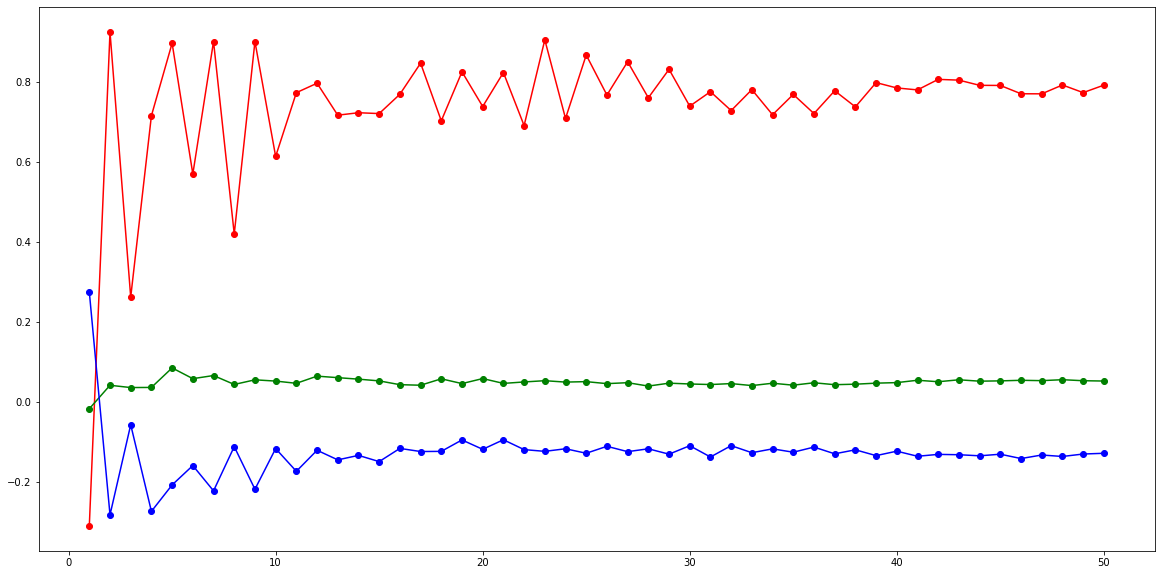

In [226]:
tt = np.linspace(-10, 10, 10)
b = [50, 2, 15]
t, ft = generate_dataset(b, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(3)
epoch = 50
lr = [10, 0.2, 0.4]
scheduler = lambda lr: np.array(lr) * np.exp(-0.01)

# n <= np.power(len(tt), 2)
n = 50
min_points = []
for batch_size in range(1, n + 1):
    min_points.append(sgd(sum_fun, x, epoch, batch_size, lr, scheduler=scheduler)[-1])

min_points = np.array(min_points)
print(b - min_points)
print(min_points)

plt.plot(np.linspace(1, n, n), (b - min_points)[:, 0], '-o', color='red')
plt.plot(np.linspace(1, n, n), (b - min_points)[:, 1], '-o', color='green')
plt.plot(np.linspace(1, n, n), (b - min_points)[:, 2], '-o', color='blue')

## SGM with momentum

[-1.17914611  0.24445029]
[8.82085389 5.24445029]
[[0.         0.        ]
 [0.73038436 4.66353743]
 [1.64630605 7.37364843]
 [2.19888933 6.27006237]
 [3.07614201 3.97395795]
 [3.90004312 3.89736216]
 [4.72492441 5.16389914]
 [5.40600337 5.62264264]
 [5.92172574 5.48170557]
 [6.41044763 5.03765297]
 [6.90896355 5.19426614]
 [7.34414568 4.89875943]
 [7.72983323 4.55078533]
 [7.99614278 4.6255481 ]
 [8.10099889 5.2664368 ]
 [8.24591305 5.02179993]
 [8.39145445 4.86333579]
 [8.47726699 4.89413262]
 [8.63459293 5.09125171]
 [8.82085389 5.24445029]]


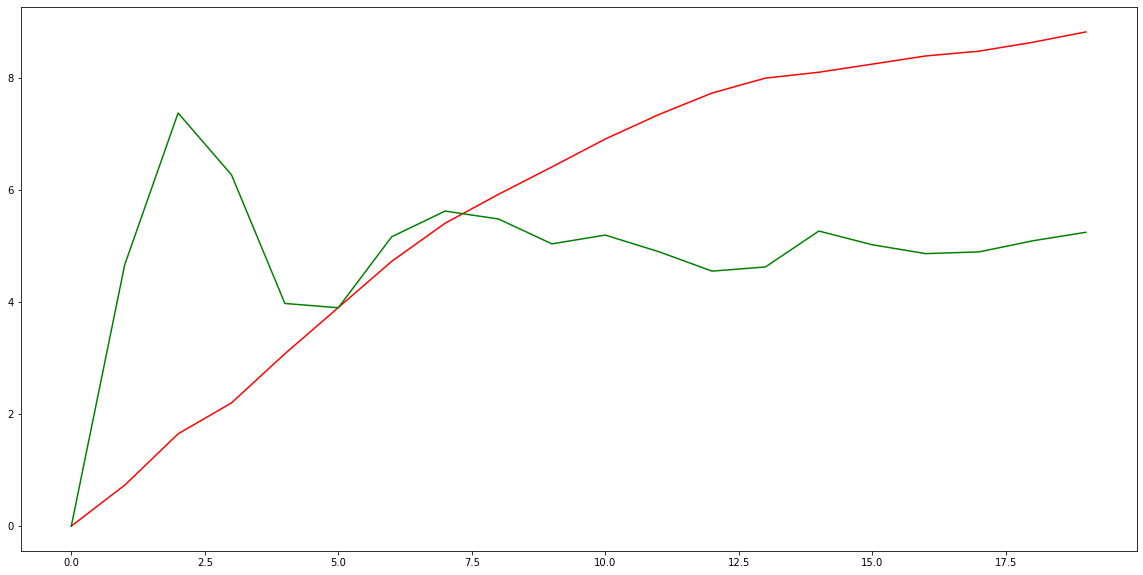

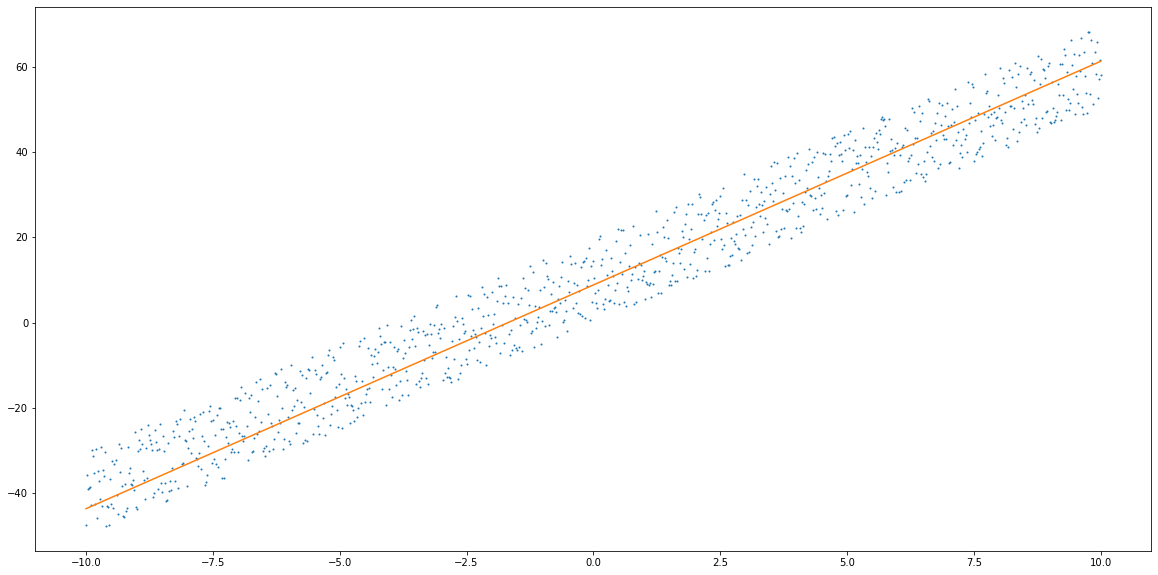

In [227]:
"""
Finds minimum of the function using stochastic gradient descent with momentum.

Единственное отличие от функции sgd в том, что добавился параметр b.
"""
def sgd_momentum(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], b:List[float] = (0), scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    g = np.array(grad_appr(sum_fun, x, [0, batch_size]))
    for i in range(1, epoch):
        g = b * g + scheduler(lr) * np.array(grad_appr(sum_fun, x, [i * batch_size, batch_size]))
        x = x - 1 / batch_size * g
        points[i] = x
    return points

tt = np.linspace(-10, 10, 1000)
a = [10, 5]
t, ft = generate_dataset(a, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = [60, 30]
b = [0.5]

points = sgd_momentum(sum_fun, x, epoch, batch_size, lr, b)
min_point = points[-1]

print(min_point - a)
print(min_point)
print(points)

ax = plt.figure().add_subplot()
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

ax = plt.figure().add_subplot()
# Plots dataset
ax.plot(t, ft, 'o', markersize=1)
# Plots approximated function
ax.plot(tt, min_point[1] * tt + min_point[0])

## Nesterov SGD

[-0.92952276  0.12133781]
[9.07047724 5.12133781]
[[0.         0.        ]
 [0.16864741 5.41006246]
 [0.8974649  7.91242811]
 [1.68455651 6.72213736]
 [2.52174398 4.25439799]
 [3.40060266 3.94711104]
 [4.19873707 4.6384445 ]
 [4.93153918 5.39329603]
 [5.58728323 5.26562903]
 [6.10657909 4.95693739]
 [6.55484274 4.7275877 ]
 [7.03251567 5.12135369]
 [7.45043526 5.22783184]
 [7.81766251 5.07116276]
 [8.12375492 4.90856608]
 [8.37899717 5.21937724]
 [8.56762792 4.99502875]
 [8.74663212 4.86118116]
 [8.92891422 4.97674835]
 [9.07047724 5.12133781]]


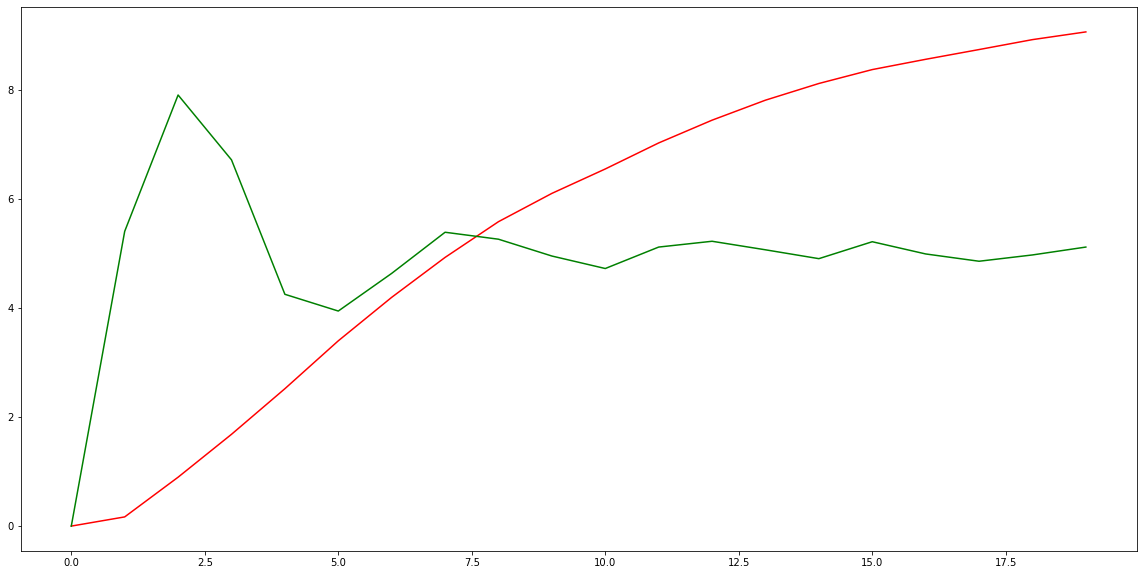

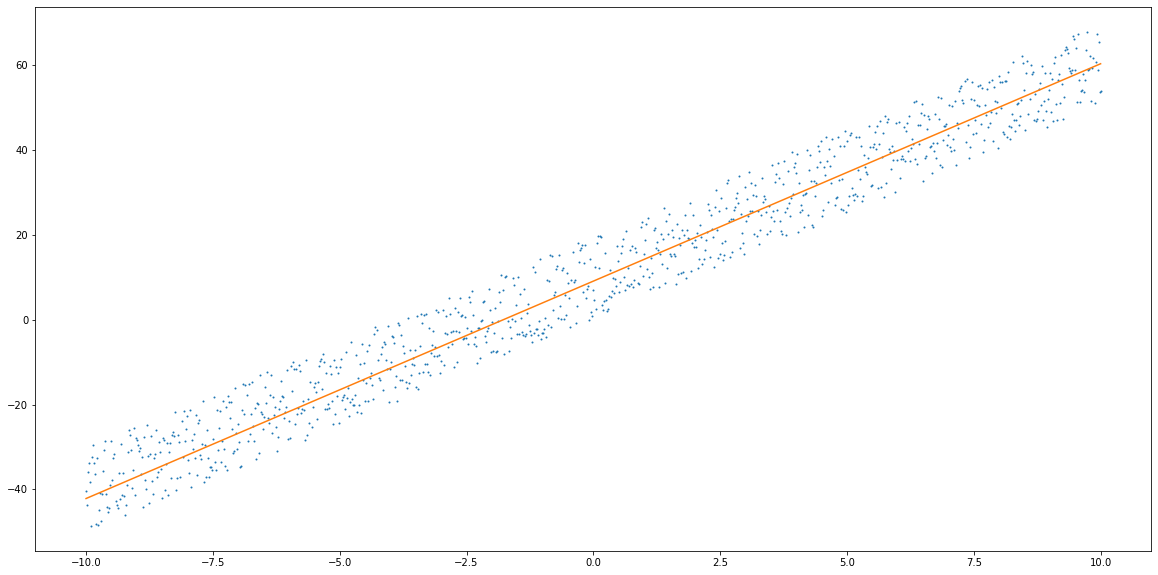

In [228]:
"""
Finds minimum of the function using stochastic gradient descent with Nesterov algorithm.
"""
def sgd_nesterov(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], b:List[float] = (0), scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    g = 0
    for i in range(1, epoch):
        g = b * g + scheduler(lr) * np.array(grad_appr(sum_fun, x - b * g, [(i - 1) * batch_size, batch_size]))
        x = x - 1 / batch_size * g
        points[i] = x
    return points

tt = np.linspace(-10, 10, 1000)
a = [10, 5]
t, ft = generate_dataset(a, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 60
lr = [60, 30]
b = [0.5]

points = sgd_momentum(sum_fun, x, epoch, batch_size, lr, b)
min_point = points[-1]

print(min_point - a)
print(min_point)
print(points)

ax = plt.figure().add_subplot()
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

ax = plt.figure().add_subplot()
# Plots dataset
ax.plot(t, ft, 'o', markersize=1)
# Plots approximated function
ax.plot(tt, min_point[1] * tt + min_point[0])

## SGD with AdaGrad

[-0.0951377  -0.05622802]
[20.0951377   5.05622802]
[[ 0.          0.        ]
 [20.         20.        ]
 [19.09300061  0.52252795]
 [15.12308125  5.61328508]
 [21.27512739  4.87490631]
 [21.31743417  4.89831489]
 [19.16256701  4.83364777]
 [20.18616909  4.66685906]
 [20.75799812  5.17932281]
 [20.3339574   5.18342478]
 [19.77616778  5.096416  ]
 [18.0406928   4.89961491]
 [20.95164443  5.21492784]
 [20.45179606  4.92193933]
 [19.87887138  5.02498392]
 [18.72472061  4.85134387]
 [21.95579347  4.79452818]
 [20.02034573  5.01415043]
 [18.40622035  4.61716791]
 [20.0951377   5.05622802]]


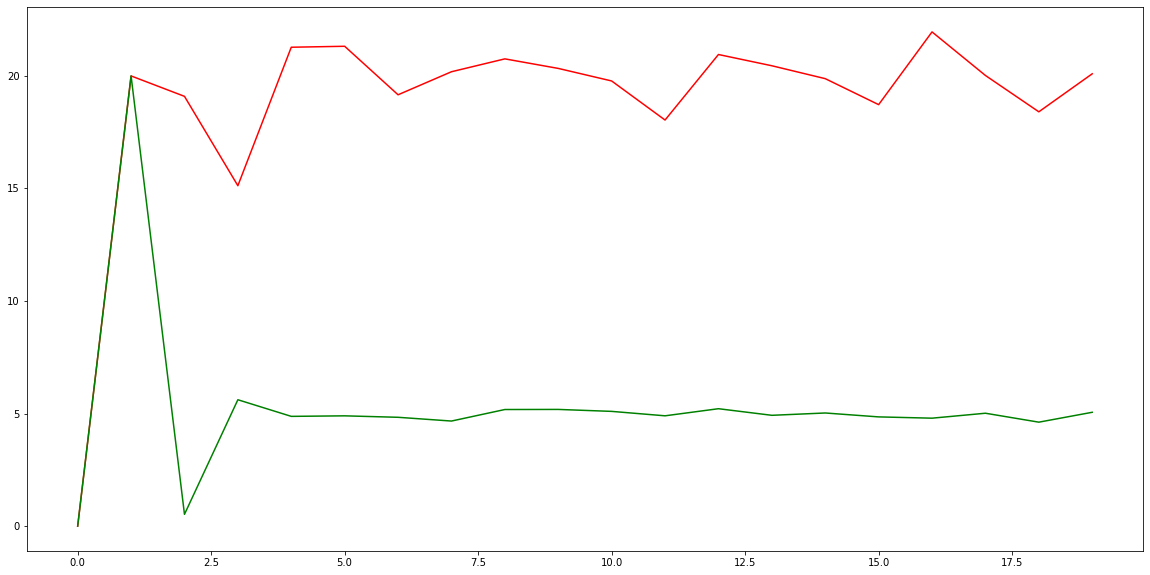

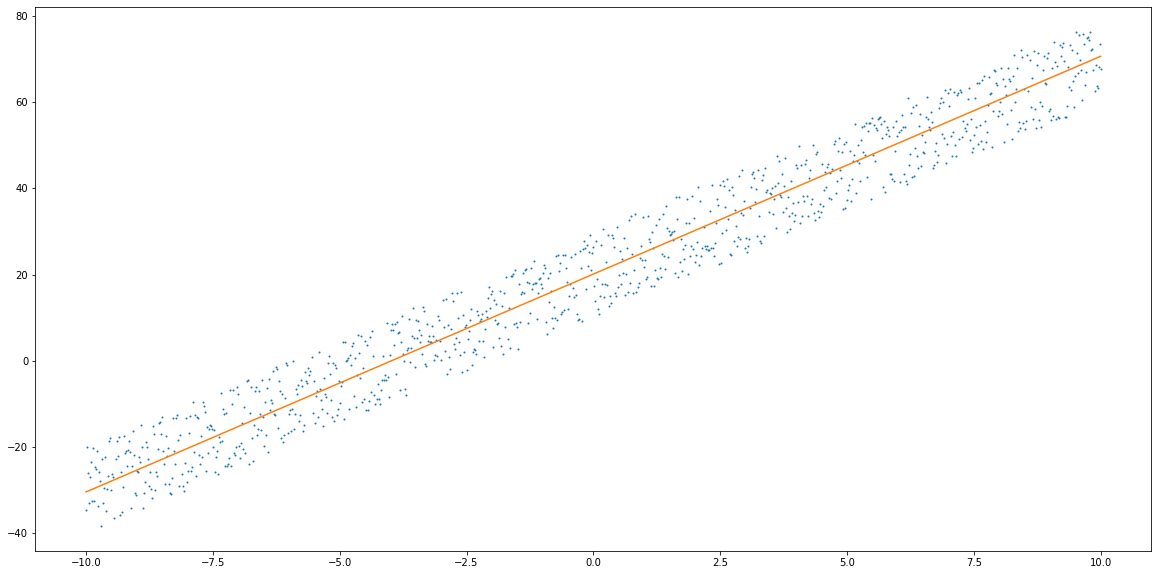

In [229]:
"""
Finds minimum of the function using stochastic gradient descent with AdaGrad (adaptive gradient).

Единственное отличие от функции sgd в том, что добавился параметр b.
"""
def sgd_adagrad(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    v = 0
    for i in range(1, epoch):
        g = np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        v += np.square(g)
        x = x - 1 / np.sqrt(v) * 1 / batch_size * scheduler(lr) * g
        points[i] = x
    return points


tt = np.linspace(-10, 10, 1000)
a = [20, 5]
t, ft = generate_dataset(a, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 50
lr = [1000]

points = sgd_adagrad(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(a - min_point)
print(min_point)
print(points)

ax = plt.figure().add_subplot()
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

ax = plt.figure().add_subplot()
# Plots dataset
ax.plot(t, ft, 'o', markersize=1)
# Plots approximated function
ax.plot(tt, min_point[1] * tt + min_point[0])

## SGD with RMSProp

[0.79287294 0.27089704]
[14.20712706  4.72910296]
[[ 0.          0.        ]
 [ 4.42718872  4.42718872]
 [ 7.16630419  5.34362561]
 [ 8.77868035  5.20110711]
 [ 9.71779513  4.92957329]
 [10.71296038  5.02506019]
 [11.67187627  5.00756535]
 [12.51426713  5.19555171]
 [13.42813745  5.11660788]
 [14.22012202  4.91980757]
 [14.14389797  5.24882511]
 [14.20357599  4.39159262]
 [14.37673477  5.45078093]
 [14.4098567   4.78124012]
 [14.42867447  5.2313137 ]
 [14.87809052  4.83912259]
 [14.93032966  5.30803501]
 [14.99925316  4.72060619]
 [14.39109267  5.17738287]
 [14.20712706  4.72910296]]


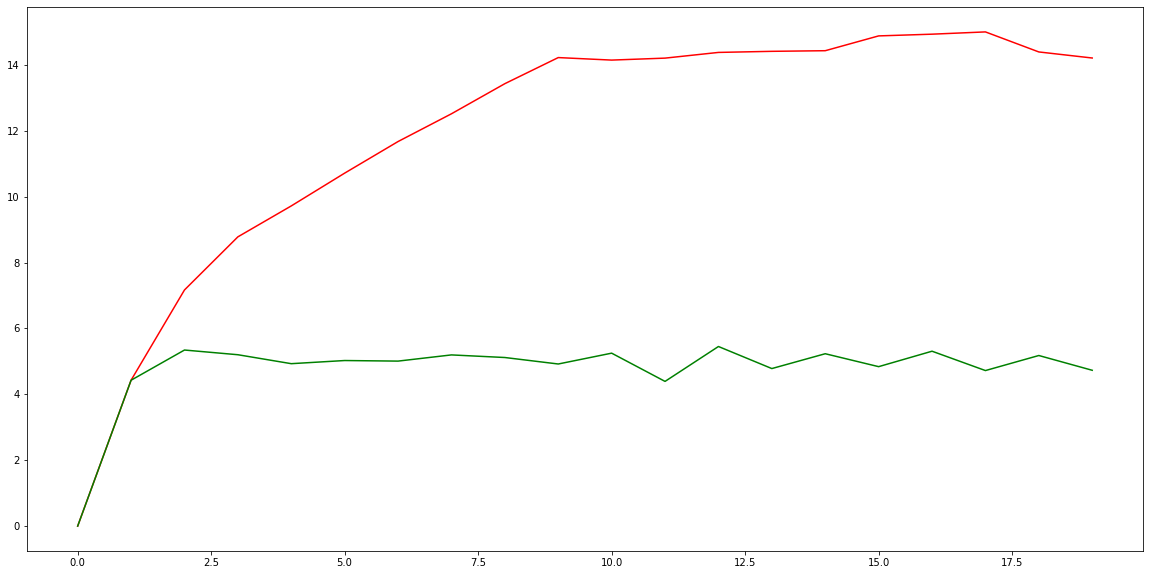

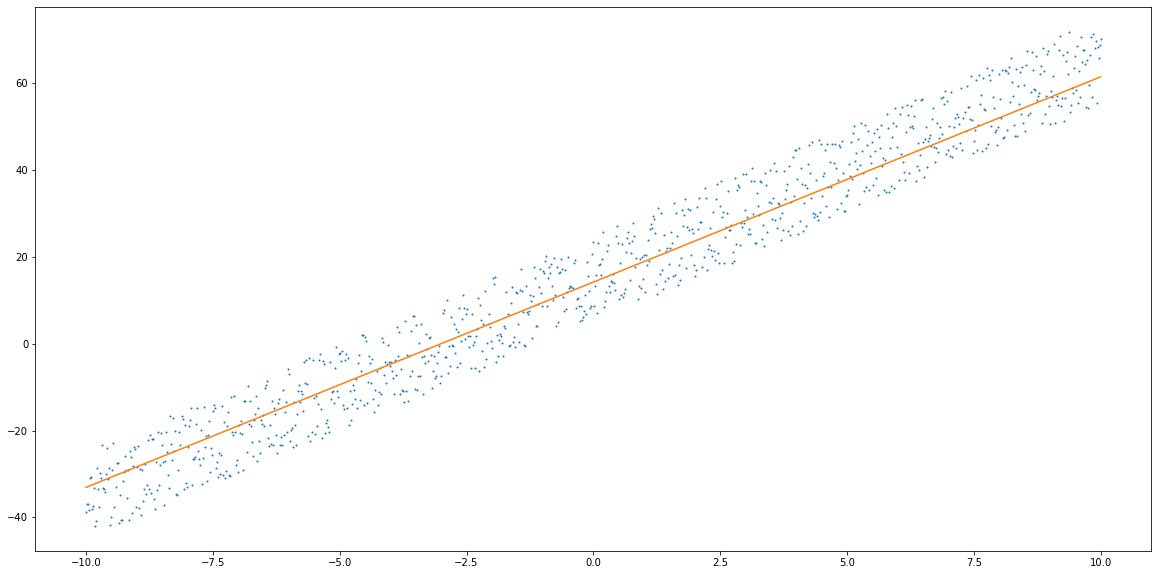

In [230]:
"""
Finds minimum of the function using stochastic gradient descent with rmsprop.
"""
def sgd_rmsprop(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], b:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    b = np.array(b)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    v = 0
    for i in range(1, epoch):
        g = np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))
        v = b * v + (1 - b) * np.square(g)
        x = x - 1 / np.sqrt(v) * 1 / batch_size * scheduler(lr) * g
        points[i] = x
    return points


tt = np.linspace(-10, 10, 1000)
a = [15, 5]
t, ft = generate_dataset(a, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 50
lr = [70]
b = [0.9]

points = sgd_rmsprop(sum_fun, x, epoch, batch_size, lr, b)
min_point = points[-1]

print(a - min_point)
print(min_point)
print(points)

ax = plt.figure().add_subplot()
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

ax = plt.figure().add_subplot()
# Plots dataset
ax.plot(t, ft, 'o', markersize=1)
# Plots approximated function
ax.plot(tt, min_point[1] * tt + min_point[0])

## SGD with Adam

[-0.69086424  0.03817122]
[15.69086424  4.96182878]
[[ 0.          0.        ]
 [ 0.95122941  0.95122942]
 [ 1.95361837  1.91643277]
 [ 2.86182101  2.76094625]
 [ 3.69028808  3.47920861]
 [ 4.49062116  4.08900951]
 [ 5.30253225  4.62266944]
 [ 6.11066543  5.06421465]
 [ 6.90995256  5.3322301 ]
 [ 7.71009417  5.33518616]
 [ 8.55698616  5.1999059 ]
 [ 9.37771199  4.95947905]
 [10.21014608  4.80785524]
 [11.00086575  4.76734911]
 [11.82665017  4.67849323]
 [12.664199    5.20506722]
 [13.49315112  5.16938777]
 [14.2852762   4.79063546]
 [15.13696337  5.10229653]
 [15.69086424  4.96182878]]


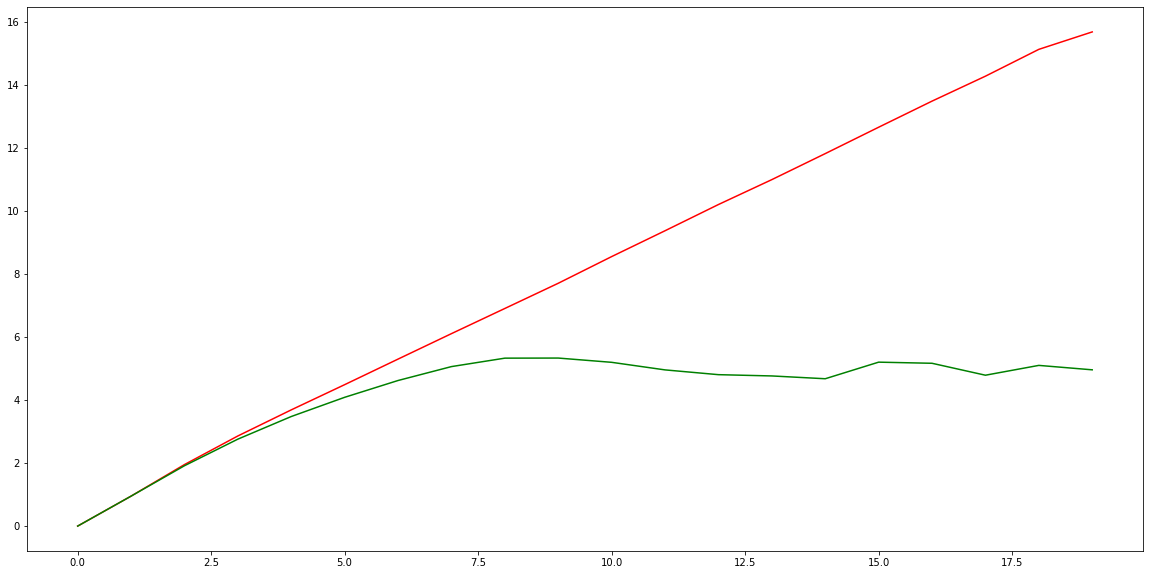

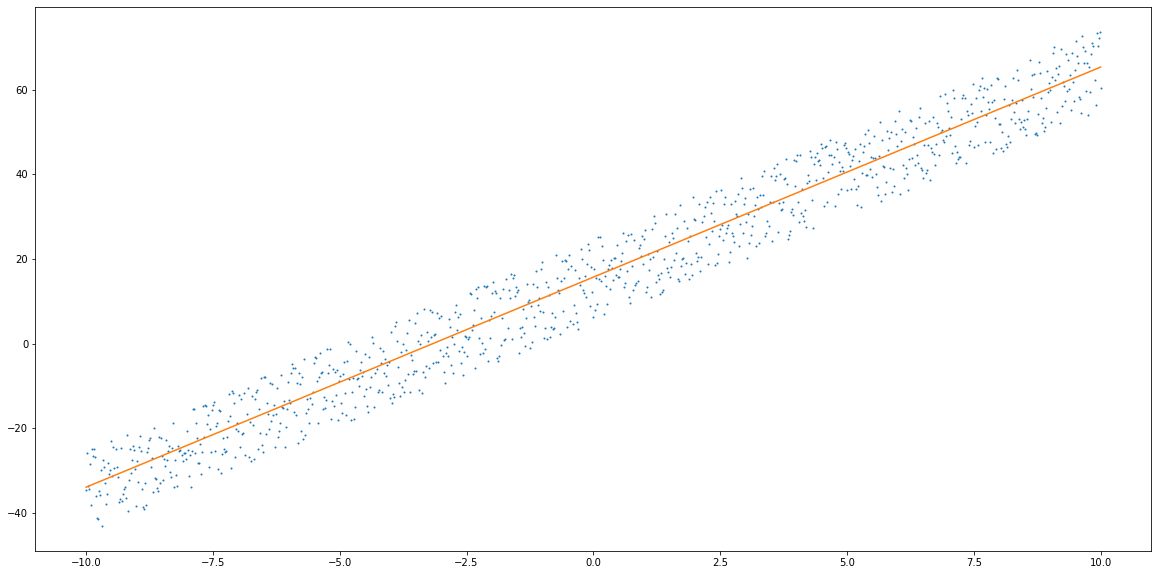

In [231]:
"""
Finds minimum of the function using stochastic gradient descent with adam.
"""
def sgd_adam(sum_fun:List[Callable[[ndarray], float]], x:ndarray, epoch:int, batch_size:int, lr:List[float], b1:List[float], b2:List[float], scheduler:Callable[[List[float]], float] = lambda lr: lr) -> ndarray:
    lr = np.array(lr)
    b1, b2 = np.array(b1), np.array(b2)
    points = np.zeros([epoch, len(x)])
    points[0] = x
    m = 0
    v = 0
    for i in range(1, epoch):
        g = np.array(grad_appr(sum_fun, x, [(i - 1) * batch_size, batch_size]))

        m = b1 * m + (1 - b1) * g
        v = b2 * v + (1 - b2) * np.square(g)

        m = m / (1 - np.power(b1, i))
        v = v / (1 - np.power(b2, i))

        x = x - 1 / (np.sqrt(v) + 1e-8) * 1 / batch_size * scheduler(lr) * m
        points[i] = x
    return points


tt = np.linspace(-10, 10, 1000)
a = [15, 5]
t, ft = generate_dataset(a, 10, tt)
sum_fun = generate_minimized_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 50
lr = [50]
b1 = [0.5]
b2 = [0.6]
scheduler = lambda lr: lr * np.exp(-0.05)

points = sgd_adam(sum_fun, x, epoch, batch_size, lr, b1, b2, scheduler=scheduler)
min_point = points[-1]

print(a - min_point)
print(min_point)
print(points)

ax = plt.figure().add_subplot()
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 0], color='red')
ax.plot(np.linspace(0, len(points) - 1, len(points)), points[:, 1], color='green')

ax = plt.figure().add_subplot()
# Plots dataset
ax.plot(t, ft, 'o', markersize=1)
# Plots approximated function
ax.plot(tt, min_point[1] * tt + min_point[0])

## Траектория спуска обычного SGD для одномерного пространства регрессоров
На графике также отображены линии равного уровня минимизируемой функции

[ 0.14801793 -0.00608757]
[ 9.85198207 -2.99391243]
[[ 0.          0.        ]
 [ 0.76012082 -0.78538699]
 [ 2.34869947 -1.69801478]
 [ 2.94048932 -1.97079749]
 [ 3.55798215 -2.19977311]
 [ 4.20018154 -2.3650533 ]
 [ 4.72901069 -2.50163161]
 [ 5.40929412 -2.78846443]
 [ 5.82940315 -2.79970802]
 [ 6.23670923 -2.82143874]
 [ 6.61103591 -2.84927633]
 [ 6.93741964 -2.86291773]
 [ 7.28920622 -2.98528648]
 [ 7.54557887 -2.96241038]
 [ 7.79671589 -2.95219083]
 [ 8.01504191 -2.95112075]
 [ 8.20915202 -2.94463133]
 [ 8.40941635 -3.01139341]
 [ 8.55698521 -2.99257699]
 [ 8.7098459  -2.98169915]
 [ 8.83685892 -2.97410515]
 [ 8.95062143 -2.96629614]
 [ 9.07028315 -3.00867747]
 [ 9.15143064 -2.99710282]
 [ 9.2452765  -2.989489  ]
 [ 9.31874646 -2.98017276]
 [ 9.38480441 -2.97370672]
 [ 9.45883962 -3.00344423]
 [ 9.50048656 -2.99710017]
 [ 9.55942658 -2.99213849]
 [ 9.60148154 -2.98223648]
 [ 9.63943065 -2.97698584]
 [ 9.68702613 -2.99963857]
 [ 9.70538544 -2.99656218]
 [ 9.74378449 -2.99330566]
 [ 

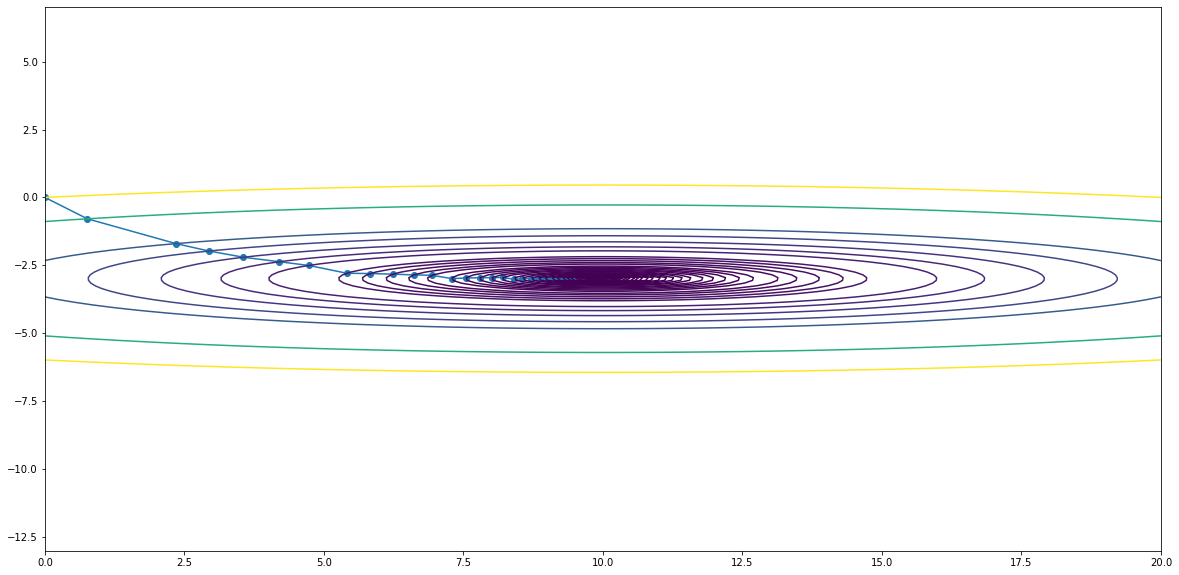

In [232]:
tt = np.linspace(-10, 10, 100)
b = [10, -3]
t, ft = generate_dataset(b, 1, tt)
sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 40
batch_size = 20
lr = [10, 0.8]

points = sgd(sum_fun, x, epoch, batch_size, lr)
min_point = points[-1]

print(b - min_point)
print(min_point)
print(points)


fun = fun_from_terms(sum_fun)

ax = plt.figure().add_subplot()
ax.plot(points[:, 0], points[:, 1], 'o-')
offset = 10
# For plot with center point in min point
ttX = np.linspace(b[0] - offset, b[0] + offset, 200)
ttY = np.linspace(b[1] - offset, b[1] + offset, 200)
X, Y = np.meshgrid(ttX, ttY)

ax.contour(X, Y, fun([X, Y]), levels=sorted([fun(point)[0] for point in points]))

## SGD with feature scaling and nomralizing
Видно, что после scaling и nomralizing функция изменяется более одинаково по всем измерениям.
Раздел в разработке. Но код для normalize и scale работает как надо

[0.5]
50.0
[-8.55722271  0.93543531]
[[-9.50000000e+00]
 [-9.29797980e+00]
 [-9.09595960e+00]
 [-8.89393939e+00]
 [-8.69191919e+00]
 [-8.48989899e+00]
 [-8.28787879e+00]
 [-8.08585859e+00]
 [-7.88383838e+00]
 [-7.68181818e+00]
 [-7.47979798e+00]
 [-7.27777778e+00]
 [-7.07575758e+00]
 [-6.87373737e+00]
 [-6.67171717e+00]
 [-6.46969697e+00]
 [-6.26767677e+00]
 [-6.06565657e+00]
 [-5.86363636e+00]
 [-5.66161616e+00]
 [-5.45959596e+00]
 [-5.25757576e+00]
 [-5.05555556e+00]
 [-4.85353535e+00]
 [-4.65151515e+00]
 [-4.44949495e+00]
 [-4.24747475e+00]
 [-4.04545455e+00]
 [-3.84343434e+00]
 [-3.64141414e+00]
 [-3.43939394e+00]
 [-3.23737374e+00]
 [-3.03535354e+00]
 [-2.83333333e+00]
 [-2.63131313e+00]
 [-2.42929293e+00]
 [-2.22727273e+00]
 [-2.02525253e+00]
 [-1.82323232e+00]
 [-1.62121212e+00]
 [-1.41919192e+00]
 [-1.21717172e+00]
 [-1.01515152e+00]
 [-8.13131313e-01]
 [-6.11111111e-01]
 [-4.09090909e-01]
 [-2.07070707e-01]
 [-5.05050505e-03]
 [ 1.96969697e-01]
 [ 3.98989899e-01]
 [ 6.01010101

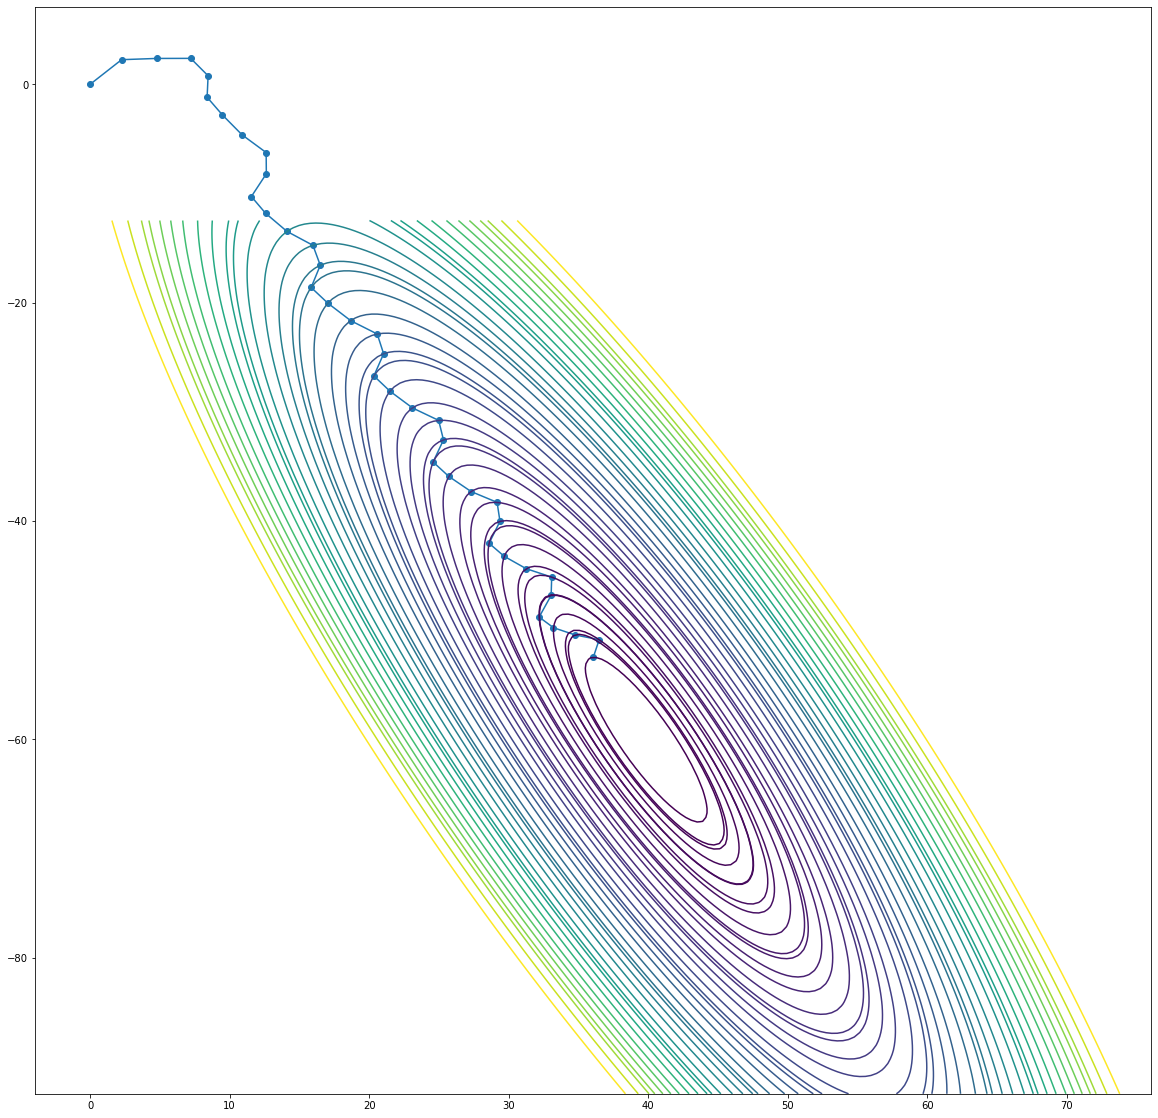

In [236]:
tt = np.linspace(-10, 10, 100)
b = [10, -3]
t, ft = generate_dataset(b, 3, tt)

"""
Normalizes features (regressors) in data instances
Mean and standard deviation after normalization equals to 0 and 1 respectively.

@param t: list of data instances

@return list of data instances with normalized features
"""
def normalize(t):
    n = len(t)
    mean = 1 / n * np.sum(t, axis=0)
    deviation = np.sqrt(1 / n * np.sum(np.square(t - mean), axis=0))
    return (t - mean) / deviation

"""
Scales features (regressors) in data instances
Every feature value is in range [0, 1] after scaling.

@param t: list of data instances

@return list of data instances with scaled features
"""
def scale(t, r=(0, 1)):
    return (t - np.min(t, axis=0)) / (np.max(t, axis=0) - np.min(t, axis=0)) * (r[1] - r[0]) + r[0]

# It needed to get min point of initial function from normalized and scaled function
n = len(t)
mean = 1 / n * np.sum(t, axis=0)
deviation = np.sqrt(1 / n * np.sum(np.square(t - mean), axis=0))

# print(t)
t = normalize(t)
mi, ma = np.min(t), np.max(t)
t = scale(t)
n = len(t)
mean = 1 / n * np.sum(t, axis=0)
print(mean)
print(np.sum(t))
print(grad(fun_from_terms(sum_fun), (1, 1)))

sum_fun = generate_minimized_two_variable_fun(t, ft)

# SGD params
x = np.zeros(2)
epoch = 40
batch_size = 20
lr = 45

points = sgd_adam(sum_fun, x, epoch, batch_size, lr, 0.5, 0.5)
min_point = points[-1]

print((t * (ma - mi) + mi) * deviation + mean)
print(mean, deviation)
print(min_point)
p = (min_point[1] * (ma - mi) + mi) * deviation + mean
print('p:', p)
print(b - p)
print(min_point)
print(points)

fun = fun_from_terms(sum_fun)

ax = plt.figure(figsize=(20, 20)).add_subplot()
ax.plot(points[:, 0], points[:, 1], 'o-')
offset = 40
# For plot with center point in min point
ttX = np.linspace(min_point[0] - offset, min_point[0] + offset, 200)
ttY = np.linspace(min_point[1] - offset, min_point[1] + offset, 200)
X, Y = np.meshgrid(ttX, ttY)

ax.contour(X, Y, fun([X, Y]), levels=np.sort(np.unique([fun(point)[0] for point in points])))

## Сравнение до и после normalizing и scaling

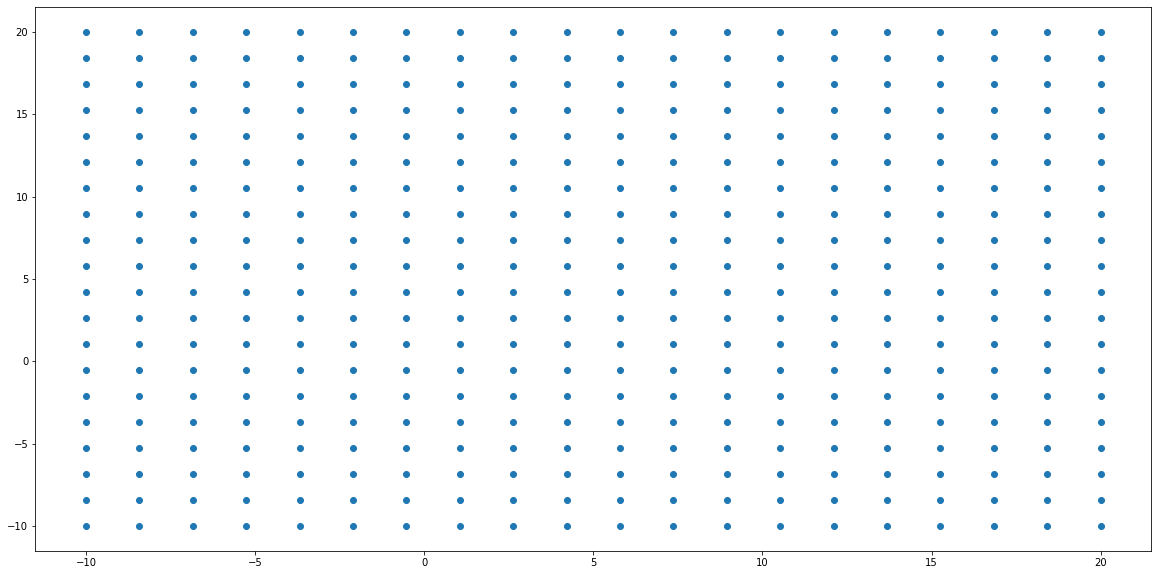

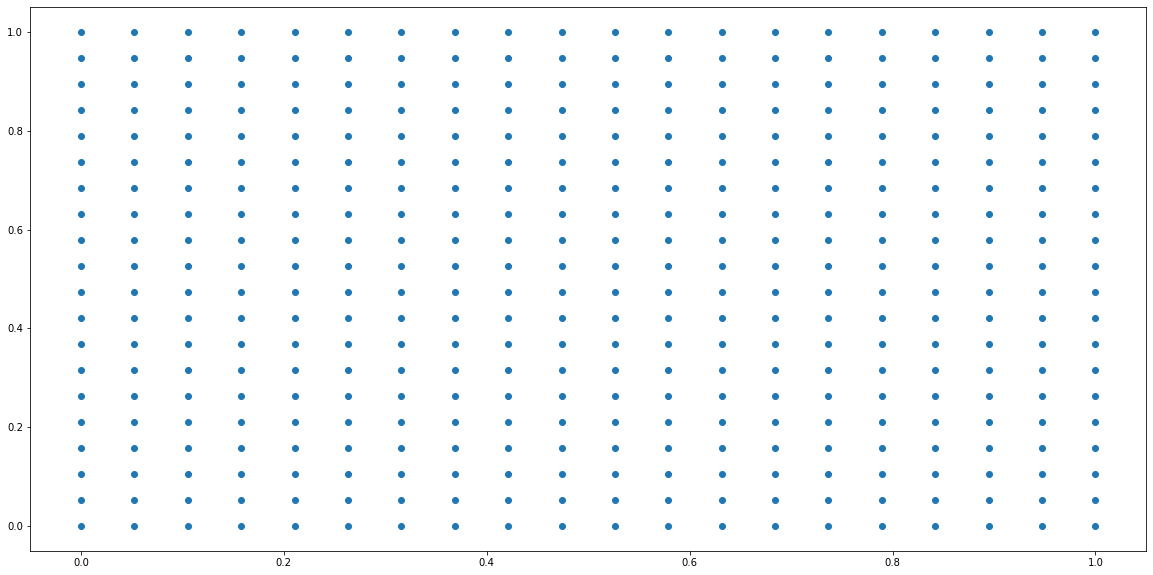

In [234]:
tt = np.linspace(-10, 20, 20)
b = [10, -3, 5]
t, ft = generate_dataset(b, 3, tt)

ax = plt.figure().add_subplot()
ax.plot(t[:, 0], t[:, 1], 'o')

t = normalize(t)
t = scale(t)
ax = plt.figure().add_subplot()
ax.plot(t[:, 0], t[:, 1], 'o')